# SPEA-II

SPEA-II is an elitist multi‐objective evolutionary algorithm that, unlike NSGA-II, does **not** use Pareto fronts. Instead, at each generation it splits the combined parents + offspring set into **non-dominated** and **dominated** individuals and maintains a separate archive of elites.

## Key Features

- **Strength & Raw Fitness**  
  1. **Strength** of individual $i$:  
     $$S(i) = \bigl|\{\,j \in P \cup A \mid i \text{ dominates } j\}\bigr|$$  
     where $P$ is the current population (size $N$) and $A$ the elite archive.  
  2. **Raw fitness** of $i$:  
     $$R(i) = \sum_{\substack{j \in P \cup A\\j \text{ dominates } i}} S(j)\,. $$

- **Density Estimation**  
  For tie-breaking among equal $R(i)$, compute  
  $$D(i) = \frac{1}{\sigma_i^k + 2},$$  
  where $\sigma_i^k$ is the distance to the $k$-th nearest neighbor in objective space. Typically $k = \lfloor\sqrt{N + A_{\max}}\rfloor$.

- **Elitist Archive**  
  - Fixed size $A_{\max}$ (often set equal to $N$).  
  - Each generation:  
    1. Form $Q = P \cup A$.  
    2. Extract all **non-dominated** from $Q$ → provisional $A'$.  
    3. If $|A'| > A_{\max}$, truncate by iteratively removing the individual with the smallest $D(i)$ until $|A'| = A_{\max}$.  
    4. If $|A'| < A_{\max}$, fill up with the best **dominated** individuals from $Q\setminus A'$ in ascending order of $F(i)=R(i)+D(i)$.

- **Environmental Selection for Mating**  
  - Parents are selected **only** from the updated archive $A_{t+1}$ (size $A_{\max}$) by binary‐tournament on $F(i)=R(i)+D(i)$.  
  - Generate exactly $N$ offspring (so offspring count = population size).

- **Survival of Population**  
  - **Population replacement** is generational: after mating, the new population $P_{t+1}$ consists **solely** of the $N$ offspring (no mixing with $P_t$).

- **Constraint Handling**  
  For constrained problems:  
  1. **Feasible** solutions always outrank infeasible ones in both archive update and tournament.  
  2. In ties raw fitness $R(i)$ is heavily penalized.  
  3. Density $D(i)$ is computed only within the feasible set to preserve feasible diversity.

---

## Implementation in pymoors

In pymoors the algorithm does not maintain a separate set A — instead, P_t itself serves as the elite archive of best individuals. Each iteration proceeds as follows:

1. **Offspring generation**  
   An offspring set O_t of size N is produced by binary-tournament selection on P_t using the composite fitness  
   $F(i) = R(i) + D(i)$.

2. **Combine parents and offspring**  
   The union  
   $Q = P_t ∪ O_t$  
   is formed.

3. **Compute metrics**  
   For every individual in Q, compute:  
   - Strength $S(i)$  
   - Raw fitness $R(i)$  
   - Density $D(i)$

4. **Build new population/archive**  
   Extract all non-dominated individuals from Q.  
   - If |non-dominated| > N, remove those with smallest $D(i)$ one by one until exactly N remain.  
   - If |non-dominated| < N, fill up with the best dominated individuals sorted by increasing $F(i)$ until the total is N.

5. **Advance to next generation**  
   The selected N individuals become P_{t+1}, which also functions as the archive for the next iteration.

This design lets the population evolve generation by generation while concurrently acting as the elite memory, without any additional archive structure.  


## ZDT6 Problem

**ZDT6** is a challenging two-objective benchmark that tests an algorithm’s ability to handle highly non-linear, multi-modal behavior and a non-uniform Pareto front.

- **Two Conflicting Objectives:**  
  - $f_{1}(\mathbf{x}) = 1 - \exp\bigl(-4\,x_{1}\bigr)\,\bigl[\sin\bigl(6\pi\,x_{1}\bigr)\bigr]^{6}$  
  - $f_{2}(\mathbf{x}) = g(\mathbf{x})\,h\bigl(f_{1}(\mathbf{x}),\,g(\mathbf{x})\bigr)$

- **Auxiliary Functions:**  
  - $g(\mathbf{x}) = 1 + 9\,\dfrac{\sum_{i=2}^{n} x_{i}}{n - 1}$  
  - $h\bigl(f_{1}, g\bigr) = 1 - \bigl(\tfrac{f_{1}}{g}\bigr)^{2}$

- **Key Characteristics:**  
  - **Multi-modal front shape:** $f_{1}$ has many local optima due to the $\sin^{6}(6\pi\,x_{1})$ term, making convergence difficult.  
  - **Non-uniform Pareto front:** Optimal solutions concentrate in a narrow region of the objective space, challenging diversity preservation.  
  - **Biased distribution:** Pareto-optimal $x_{1}$ values are skewed toward the middle of the decision range.  
  - **Non-convexity:** The $h$ function introduces strong curvature, requiring careful balance between convergence and spread.

- **Domain:**  
  Each decision variable $x_{i}\in[0,1]$, typically with $n=30$.

ZDT6 is ideal for evaluating how well an algorithm balances exploration of multiple local optima in $f_{1}$ with exploitation toward a concentrated, non-uniform Pareto front.  


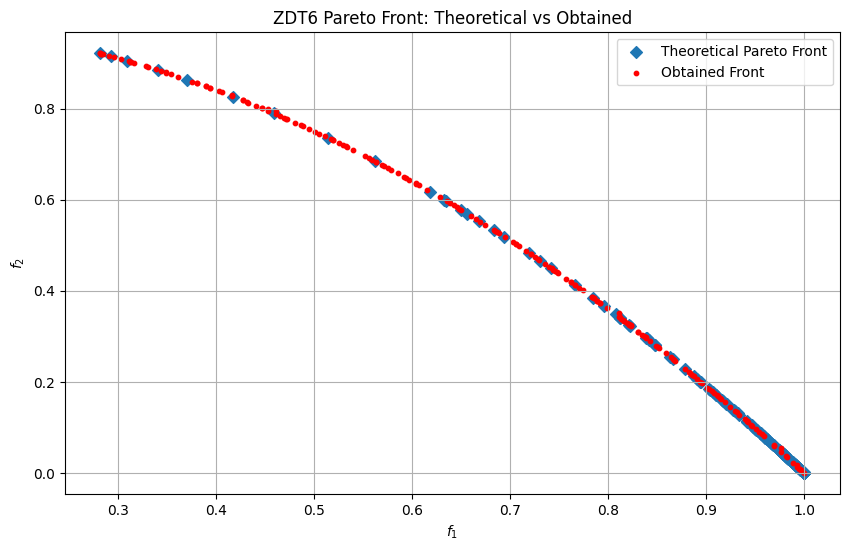

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from pymoors import (
    Spea2,
    RandomSamplingFloat,
    GaussianMutation,
    ExponentialCrossover,
    CloseDuplicatesCleaner
)
from pymoors.schemas import Population
from pymoors.typing import TwoDArray


def evaluate_zdt6(population: TwoDArray) -> TwoDArray:
    """
    Evaluate the ZDT6 objectives in a fully vectorized manner.
    """
    x1 = population[:, 0]
    n = population.shape[1]
    # g = 1 + (9/(n-1)) * sum(x[1:])
    g = 1 + (9 / (n - 1)) * np.sum(population[:, 1:], axis=1)
    # f1 = 1 - exp(-4*x1) * sin^6(6*pi*x1)
    f1 = 1 - np.exp(-4 * x1) * np.sin(6 * np.pi * x1)**6
    # h = 1 - (f1/g)^2
    h = 1 - (f1 / g)**2
    # f2 = g * h
    f2 = g * h
    return np.column_stack((f1, f2))

def zdt6_theoretical_front(num_points=200):
    """
    Compute the theoretical Pareto front for ZDT6.
    """
    x1 = np.linspace(0, 1, num_points)
    f1 = 1 - np.exp(-4 * x1) * np.sin(6 * np.pi * x1)**6
    # when g = 1 → f2 = 1 - f1^2
    f2 = 1 - f1**2
    return f1, f2

# Set up the SPEA2 algorithm for ZDT6
algorithm = Spea2(
    sampler=RandomSamplingFloat(min=0, max=1),
    crossover=ExponentialCrossover(exponential_crossover_rate=0.75),
    mutation=GaussianMutation(gene_mutation_rate=0.1, sigma=0.01),
    fitness_fn=evaluate_zdt6,
    duplicates_cleaner=CloseDuplicatesCleaner(epsilon=1e-8),
    num_objectives=2,
    num_vars=30,
    population_size=200,
    num_offsprings=200,
    num_iterations=500,
    mutation_rate=0.1,
    crossover_rate=0.9,
    keep_infeasible=False,
    upper_bound=1,
    lower_bound=0,
    verbose=False
)

# Run SPEA2 on ZDT6
algorithm.run()

# Extract the obtained Pareto front
best: Population = algorithm.population.best_as_population
obtained_fitness = best.fitness
f1_found = obtained_fitness[:, 0]
f2_found = obtained_fitness[:, 1]

# Compute the theoretical front
f1_theo, f2_theo = zdt6_theoretical_front()

# Plot theoretical vs obtained
plt.figure(figsize=(10, 6))
plt.scatter(f1_theo, f2_theo, marker='D', label='Theoretical Pareto Front')
plt.scatter(f1_found, f2_found, c='r', marker='o', s=10, label='Obtained Front')
plt.xlabel('$f_1$')
plt.ylabel('$f_2$')
plt.title('ZDT6 Pareto Front: Theoretical vs Obtained')
plt.legend()
plt.grid(True)
plt.show()